Нам дан набор котировок за несколько минут по условному активу.
Необходимо построить модель трёх-барьерного алгоритма на основе методики Маркоса Лореза Де Прадо, описанной в книге "Машинное обучение. Алгоритмы для бизнеса". 

Выполнил Александр Кретов +7 906 673 0710, Telegram: @aakretov.  



In [27]:
import pandas as pd
import datetime
from datetime import datetime, timedelta
import mplfinance as mpf
import numpy as np
import tqdm
from tqdm import tqdm, trange
from os import listdir
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as scs
from matplotlib.pyplot import figure
%matplotlib inline
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from numpy.lib.stride_tricks import sliding_window_view
import warnings
import logging
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import  mean_squared_error
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statistics import mean
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
warnings.filterwarnings('ignore')
logging.getLogger("prophet").setLevel(logging.ERROR)
logging.getLogger("cmdstanpy").setLevel(logging.ERROR)
logging.getLogger('fbprophet').setLevel(logging.ERROR)
logging.getLogger('fbprophet').disabled = True


In [70]:
RANDOM_STATE = 654321

In [2]:
MY_PATH = "E://Data//JobSeek//Техзадания//NASCA//gz"

In [3]:
onlyfiles = [f for f in listdir(MY_PATH) if f.__contains__(".log")]
onlyfiles[:3]

['2023-10-01_practice.log',
 '2023-10-02_practice.log',
 '2023-10-03_practice.log']

In [4]:
data = []
for file_path in tqdm(onlyfiles):
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            date = parts[0]
            time = parts[1]
            price = float(parts[-2])
            volume = float(parts[-1])
        
            data.append({'1': date, '2': time, '4': price, '5': volume})
# Create a DataFrame
data = pd.DataFrame(data)

100%|██████████| 59/59 [00:20<00:00,  2.88it/s]


In [5]:
data.columns = ["date", "time", "price", "volume"]
data["datetime"] = pd.to_datetime(
    data["date"] + " " + data["time"], format="%d.%m.%Y %H:%M:%S.%f"
)
data.set_index("datetime", inplace=True)
data.drop(["date", "time"], axis=1, inplace=True)
data.sort_index(ascending=False,inplace=True)
data.head()

,price,volume
datetime,,
2023-11-28 14:02:16.393390,7.519,0.2
2023-11-28 14:02:16.393314,7.519,66.5
2023-11-28 14:02:16.393133,7.518,18.4
2023-11-28 14:02:16.393110,7.517,26.6
2023-11-28 14:02:16.393103,7.516,81.0


In [6]:
data.isna().sum()

price     0
volume    0
dtype: int64

# Моделирование  
Наша модель будет основана на следующих допущениях  
1) Мы не може иметь отрицательный баланс денежных средств  
2) Мы не можем открывать короткие позиции, т.е. можем продать только те активы, которые у на сесть на балансе.  
3) За кажду транзакцию мы платим комиссию в размере некоторого процента от суммы сделки, и он одинаковый для всех сделок.

## Вспомогательные функции

In [7]:
def candel_formater(data, period):
    """
    Преобразуем график цен в набор данных пригодный для построения графика свечей

    Args:
        data (dataframe): набор данных, где индекс это время, есть колонки 'price' - цена и 'volume' - объём.
        period (str): временной период для построения свечек.

    Return:
        df (dataframe): набор данных в формате пригодном для построяние свечевого графика.
    """
    df = data.resample(period).agg({"price": "ohlc", "volume": "sum"})
    df.columns = df.columns.droplevel()
    df.dropna(inplace=True)
    df = df.loc[df.volume > 0, :]
    return df

In [8]:
def get_daily_vol(close, lookback=50):
    """
    :param close: (data frame) Цены закрытия
    :param lookback: (int) длинна предшествующего периода для рассчёта волатильности
    :return: (series) набор данных с ежедневной волательностью, вычисляемой как скользящее стандартное отклонение
    """
    #print('Рассчитываем скользящую волатильность для порогов')

    df0 = close.pct_change().rolling(lookback).std()
    return df0

In [9]:
df = candel_formater(data, "1s")
df.head()

,open,high,low,close,volume
datetime,,,,,
2023-11-28 14:01:00,14.743,14.844,14.370,14.668,249435.1
2023-11-28 14:01:01,14.429,15.067,13.457,14.240,8824924.4
2023-11-28 14:01:02,14.330,15.313,13.281,15.238,8015846.3
2023-11-28 14:01:03,14.172,15.309,13.209,14.378,7335404.5
2023-11-28 14:01:04,14.378,15.190,13.224,14.653,9517159.2


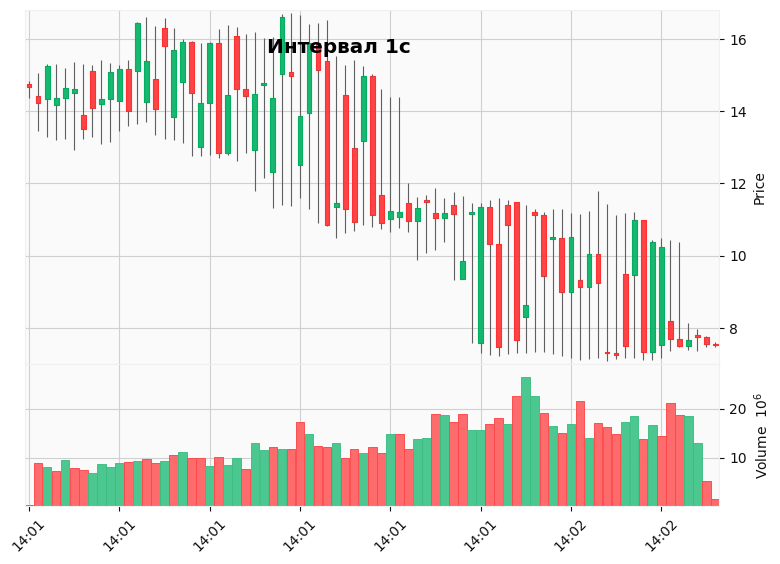

In [10]:
mpf.plot(
    df,
    type="candle",
    volume=True,
    title="Интервал 1с",
    tight_layout=True,
    style="yahoo",
)

In [11]:
close = df['close']
# Определяем скользящую волатильность, исходя из 5 прошлых свечей
vol = get_daily_vol(close=close, lookback=5)
df['vol']=vol
df

,open,high,low,close,volume,vol
datetime,,,,,,
2023-11-28 14:01:00,14.743,14.844,14.370,14.668,249435.1,NaN
2023-11-28 14:01:01,14.429,15.067,13.457,14.240,8824924.4,NaN
2023-11-28 14:01:02,14.330,15.313,13.281,15.238,8015846.3,NaN
2023-11-28 14:01:03,14.172,15.309,13.209,14.378,7335404.5,NaN
2023-11-28 14:01:04,14.378,15.190,13.224,14.653,9517159.2,NaN
...,...,...,...,...,...,...
2023-11-28 14:02:12,7.704,10.382,7.472,7.500,18641189.8,0.289546
2023-11-28 14:02:13,7.500,8.126,7.385,7.670,18535132.4,0.239601
2023-11-28 14:02:14,7.809,7.974,7.360,7.753,12959300.3,0.111620


In [12]:
def set_h_barriers(data, alpha=0.75):
    """
    Функция устанавливает для данной точки горизонтальные барьеры
    :data: (pd.Dataframe) набор данных, в котором обязательно есть колонка closed и vol в который будут добавленны горизонатльные барьеры
    :alpha: (float) коэффициент риск-апетита, показывающий во сколько раз наши пороги take-profit и stop-loss отлиаются от скользящей волатильности
    :return: (pd.Dataframe) изменённый датафрейм, как исходный, но добавлены значения горизонатлных барьеров
    """
    d0 = data.copy()
    d0 = d0.fillna(-1)
    d0['stop_loss'] = d0['close'] - d0['vol'] * alpha
    d0['take_profit'] = d0['close'] + d0['vol'] * alpha
    for index, row in d0.iterrows():
        if row['vol']==-1:
            d0['vol'].loc[index]=np.nan
            d0['stop_loss'].loc[index]=np.nan
            d0['take_profit'].loc[index]=np.nan
    return d0
        

In [13]:
df = set_h_barriers(df, alpha=0.75)
df

,open,high,low,close,volume,vol,stop_loss,take_profit
datetime,,,,,,,,
2023-11-28 14:01:00,14.743,14.844,14.370,14.668,249435.1,NaN,NaN,NaN
2023-11-28 14:01:01,14.429,15.067,13.457,14.240,8824924.4,NaN,NaN,NaN
2023-11-28 14:01:02,14.330,15.313,13.281,15.238,8015846.3,NaN,NaN,NaN
2023-11-28 14:01:03,14.172,15.309,13.209,14.378,7335404.5,NaN,NaN,NaN
2023-11-28 14:01:04,14.378,15.190,13.224,14.653,9517159.2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-11-28 14:02:12,7.704,10.382,7.472,7.500,18641189.8,0.289546,7.282841,7.717159
2023-11-28 14:02:13,7.500,8.126,7.385,7.670,18535132.4,0.239601,7.490300,7.849700
2023-11-28 14:02:14,7.809,7.974,7.360,7.753,12959300.3,0.111620,7.669285,7.836715


In [14]:
# добавляем вертикальный барьер
time_to_hold = 1
df['exit_postion'] = df.index+timedelta(seconds=time_to_hold)
df

,open,high,low,close,volume,vol,stop_loss,take_profit,exit_postion
datetime,,,,,,,,,
2023-11-28 14:01:00,14.743,14.844,14.370,14.668,249435.1,NaN,NaN,NaN,2023-11-28 14:01:01
2023-11-28 14:01:01,14.429,15.067,13.457,14.240,8824924.4,NaN,NaN,NaN,2023-11-28 14:01:02
2023-11-28 14:01:02,14.330,15.313,13.281,15.238,8015846.3,NaN,NaN,NaN,2023-11-28 14:01:03
2023-11-28 14:01:03,14.172,15.309,13.209,14.378,7335404.5,NaN,NaN,NaN,2023-11-28 14:01:04
2023-11-28 14:01:04,14.378,15.190,13.224,14.653,9517159.2,NaN,NaN,NaN,2023-11-28 14:01:05
...,...,...,...,...,...,...,...,...,...
2023-11-28 14:02:12,7.704,10.382,7.472,7.500,18641189.8,0.289546,7.282841,7.717159,2023-11-28 14:02:13
2023-11-28 14:02:13,7.500,8.126,7.385,7.670,18535132.4,0.239601,7.490300,7.849700,2023-11-28 14:02:14
2023-11-28 14:02:14,7.809,7.974,7.360,7.753,12959300.3,0.111620,7.669285,7.836715,2023-11-28 14:02:15


Но конечно, все эти рассчёты бесполезны, если мы не будем делать их на прогнозных данных, а потом при появлении реальных котировок отдавать приказы на покупку и продажу.
Так что самое время знаяться прогнозированием котировок, хоть это и неблагодарное занятие.

In [15]:
dft = candel_formater(data, "20ms")
dft.shape

(3755, 5)

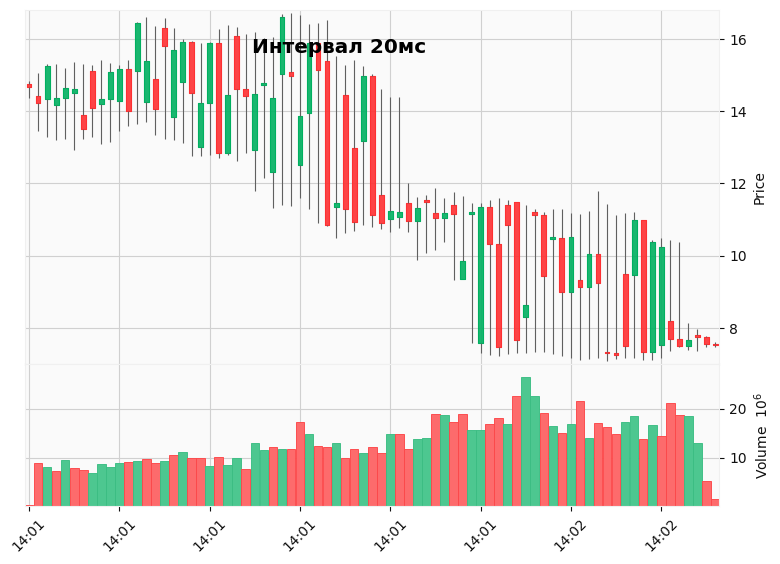

In [28]:
mpf.plot(
    df,
    type="candle",
    volume=True,
    title="Интервал 20мс",
    tight_layout=True,
    style="yahoo",
)

Нам достался непростой ряд, у него безусловно есть трендовая составляющая и значительные неидентифицированные остатки.

In [29]:
#Убедимся в том, что наш временной ряд нестационарный. Для этого применим расширенный тест Дики – Фуллера
result = adfuller(dft['close'], autolag='AIC')

print('Критерий ADF: %f' % result[0])

print('P-значение: %f' % result[1])
print("Примем нулевую гипотезу о том, что временной ряд нестационерен (его среднее и cтандарное значение изменяются).")

print('Критические значения:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] < result[4][key]:
        print ("Нулевая гипотеза отвергнута – Временной ряд стационарен")
    else:
        print ("Нулевая гипотеза не отвергнута – Временной ряд не стационарен")

Критерий ADF: -0.152171
P-значение: 0.943988
Примем нулевую гипотезу о том, что временной ряд нестационерен (его среднее и cтандарное значение изменяются).
Критические значения:
	1%: -3.432
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	5%: -2.862
Нулевая гипотеза не отвергнута – Временной ряд не стационарен
	10%: -2.567
Нулевая гипотеза не отвергнута – Временной ряд не стационарен


Критерий Дики-Фуллера: p=0.943988


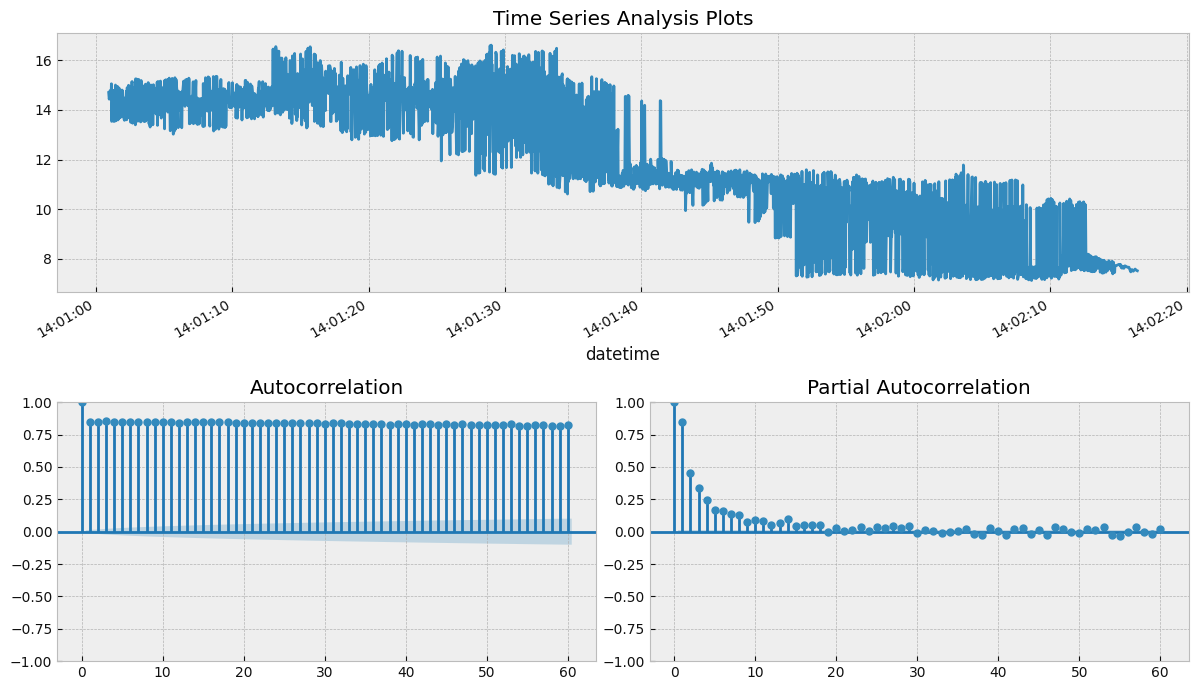

In [30]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
    Функция рисует графики иллюстрирующие стационарность/нестационарность временного ряда, и считает критерий Дикки-Фуллера
    :param y: (series) набор значений, который надо подвергнуть преобразованию
    :param lags: (numeric) лаги для отрисовки сезонности на графиках
    :param figsize (tulpe (x,y)) - размер фигуры для отображения графиков
    :param style: (code_name) - стиль для отрисовки графика из следующего списка:
        ['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh',
        'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 
        'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind',
        'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 
        'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel',
        'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid',
        'tableau-colorblind10']
    :return: ничего не возращает, просто рисует графики и пишет чему равен критерий Дикки-Фуллера
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dft['close'], lags=60)

Попробуем стабилизировать дисперсию преоразованием Бокса-Кокса.

Критерий Дики-Фуллера: p=0.937879
Оптимальный параметр преобразования Бокса-Кокса: 1.417509


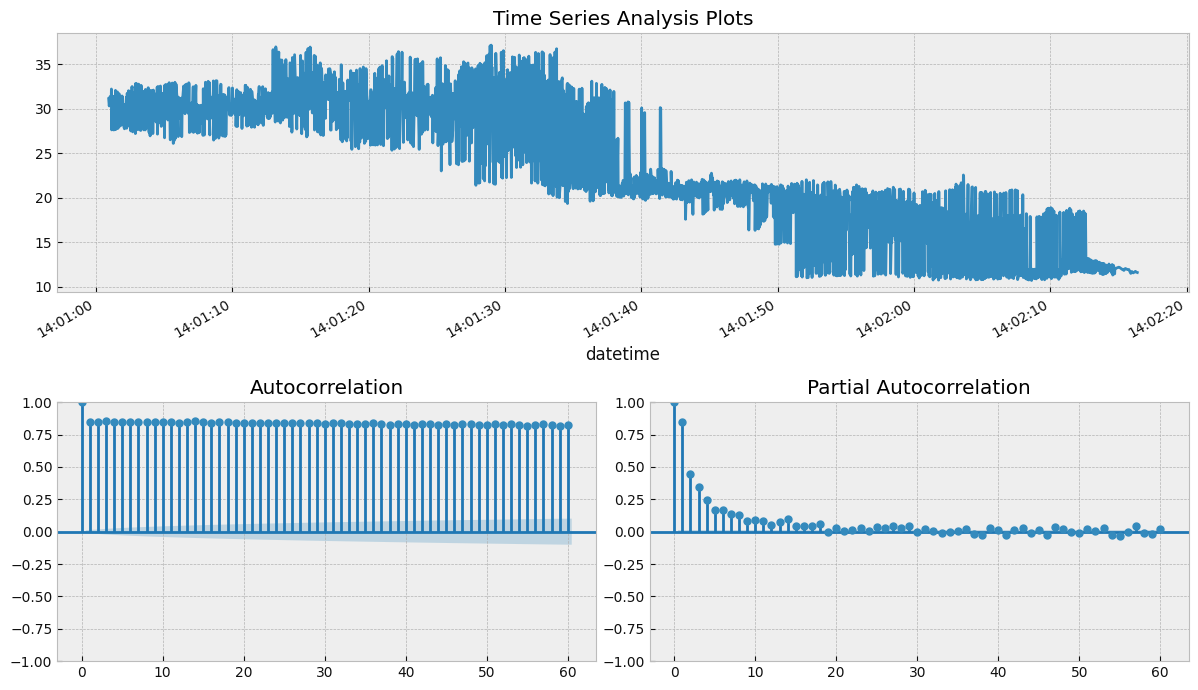

In [31]:
def invboxcox(y,lmbda):
    """
    Функция осуществляет обратно преобразование Бокса-Кокса
    :param y: (series) набор значений, который надо подвергнуть преобразованию
    :param lmbda: (float) параметр преобразования Бокса-Кокса
    :return: (series) если lmbda = 0 функция вернёт экспоненту от входного набора данных, а если нет то подвергнет его полному преобразованию
    """

    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

dtf_cox = dft.copy()
dtf_cox['close_box'], lmbda = scs.boxcox(dtf_cox.close)
tsplot(dtf_cox.close_box, lags=60)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Вообще никакого эффекта. Будем применять только те модели,которые самостоятельно убирают трендовую и сезонную составляющие.

In [32]:
tscv = TimeSeriesSplit(n_splits=3)

In [33]:
train_size=int(round(0.8*len(dft),0))

In [34]:
#Создадим датафрейм для хранения данных по кросс-валидации наших моделей
eva=pd.DataFrame(columns=['Model','RMSE Fold1','RMSE Fold2','RMSE Fold3','Усреднённое RMSE','time'])


# Модель на базе STL



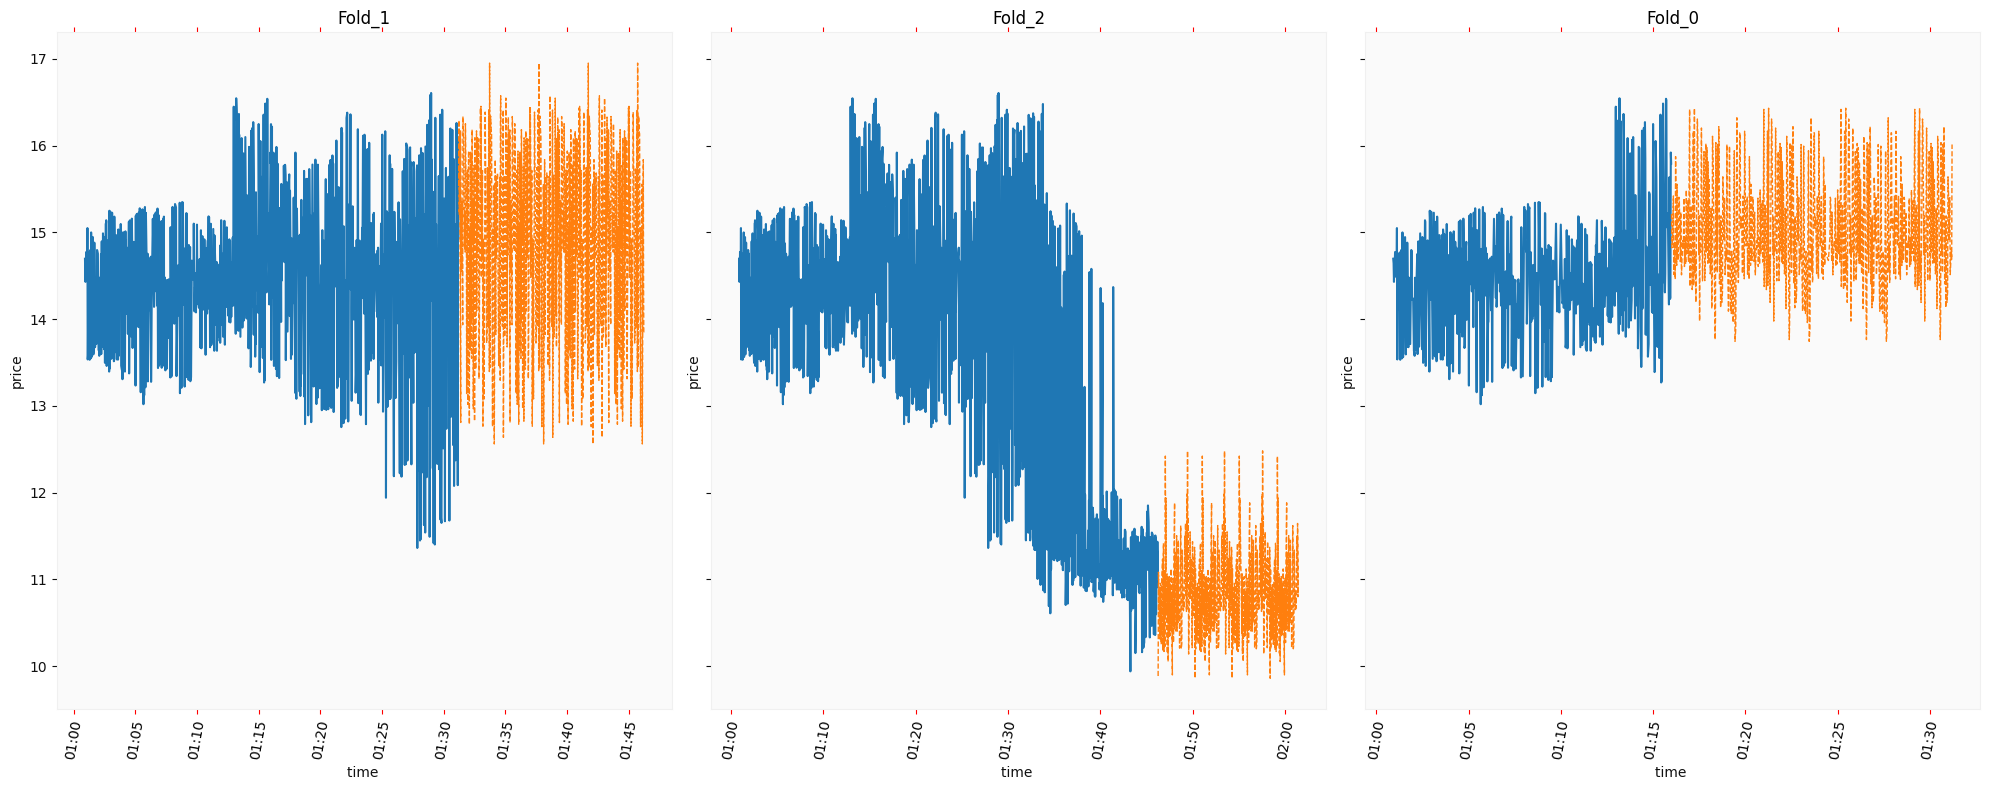

Результаты кросс-валидации STL-модели  [1.3373574575414775, 3.3429882098092865, 1.5727778928788667] максимальное время обучения фолда = 0.429003


In [35]:
rmsez=[]
formatter = mdates.DateFormatter('%M:%S')
t=dft['close'][:train_size]
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))
max_time = 0
for fold, (train_index, test_index) in enumerate(tscv.split(t)):
    t_start = datetime.now()
    model = STLForecast(t.iloc[train_index], ARIMA, model_kwargs={"order": (2, 1, 0)}, period=200)
    res = model.fit()
    pred=res.forecast(len(test_index))
    loss = mean_squared_error(t.iloc[test_index], pred, squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(t.iloc[train_index].index, t.iloc[train_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='price',title='Fold_{}'.format(fold))
    axs[fold-1].plot(t.iloc[test_index].index, pred,'--',linewidth=1)

    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
    axs[fold-1].tick_params(top=True, labeltop=False, color='red', axis='x',
               labelcolor='black', rotation=80)
    fold=fold+1
    t_end = datetime.now()
    max_time =max(max_time, (t_end-t_start).total_seconds())

plt.show()
print("Результаты кросс-валидации STL-модели ",rmsez, "максимальное время обучения фолда =", max_time)

In [36]:
l=['STL']+rmsez+[mean(rmsez)]+[max_time]
eva.loc[len(eva)] = l
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE,time
0,STL,1.337357,3.342988,1.572778,2.084375,0.429003


# Модель на базе библиотеки prophet от Facebook  
Теперь попробуем спрогнозировать с помощью библиотеки prophet

In [37]:
#Подготовим исходные данные для обучения "пророка", так как у него свои требования к формату входных данных
df_pr = pd.DataFrame()
df_pr['close'] = dft['close'][:train_size]
df_pr['date'] = df_pr.index
df_pr = df_pr.rename(columns={'date': 'ds', 'close': 'y'})
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3004 entries, 2023-11-28 14:01:00.920000 to 2023-11-28 14:02:01.360000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   y       3004 non-null   float64       
 1   ds      3004 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 70.4 KB


In [38]:
#Инициализируем модель
m = Prophet(weekly_seasonality=False)
m.add_seasonality(name='second', period=20, fourier_order=5)
m.add_seasonality(name='10second', period=200, fourier_order=5)
m.fit(df_pr)

18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
#Создадтим будущее размером с нашу тестовую выборку, и с периодичностью в 20 ms
test_size=len(dft)-train_size
future = m.make_future_dataframe(periods=test_size*3,freq='20ms')
future.tail()

,ds
5252,2023-11-28 14:02:46.340
5253,2023-11-28 14:02:46.360
5254,2023-11-28 14:02:46.380
5255,2023-11-28 14:02:46.400
5256,2023-11-28 14:02:46.420


In [40]:
#Создадим прогноз:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
5252,2023-11-28 14:02:46.340,4.471320,0.385512,8.635452
5253,2023-11-28 14:02:46.360,4.469195,0.340181,8.561056
5254,2023-11-28 14:02:46.380,4.467070,0.356667,8.756794
5255,2023-11-28 14:02:46.400,4.464945,0.570119,8.852442
5256,2023-11-28 14:02:46.420,4.462819,0.262794,8.676191


In [41]:
forecast.shape

(5257, 19)

Text(91.97222222222221, 0.5, 'Цена')

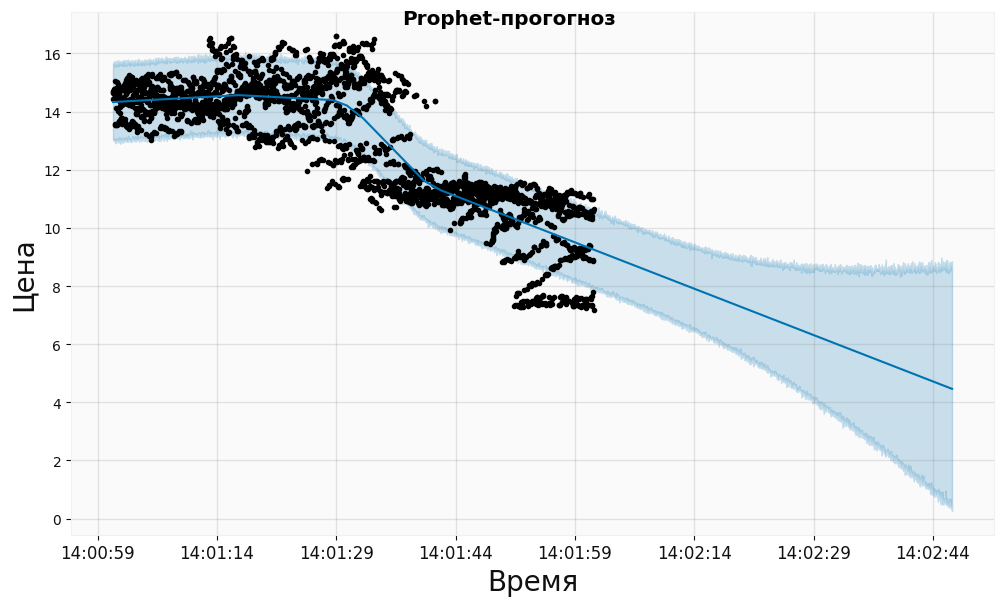

In [42]:
#Посмоитрим как это выглядит на графике
plt.rcParams["xtick.labelsize"] = 12
fig1 = m.plot(forecast)
fig1.suptitle('Prophet-прогогноз',fontsize='x-large', fontweight='bold')
plt.xlabel("Время", fontsize=20)
plt.ylabel("Цена",fontsize=20)

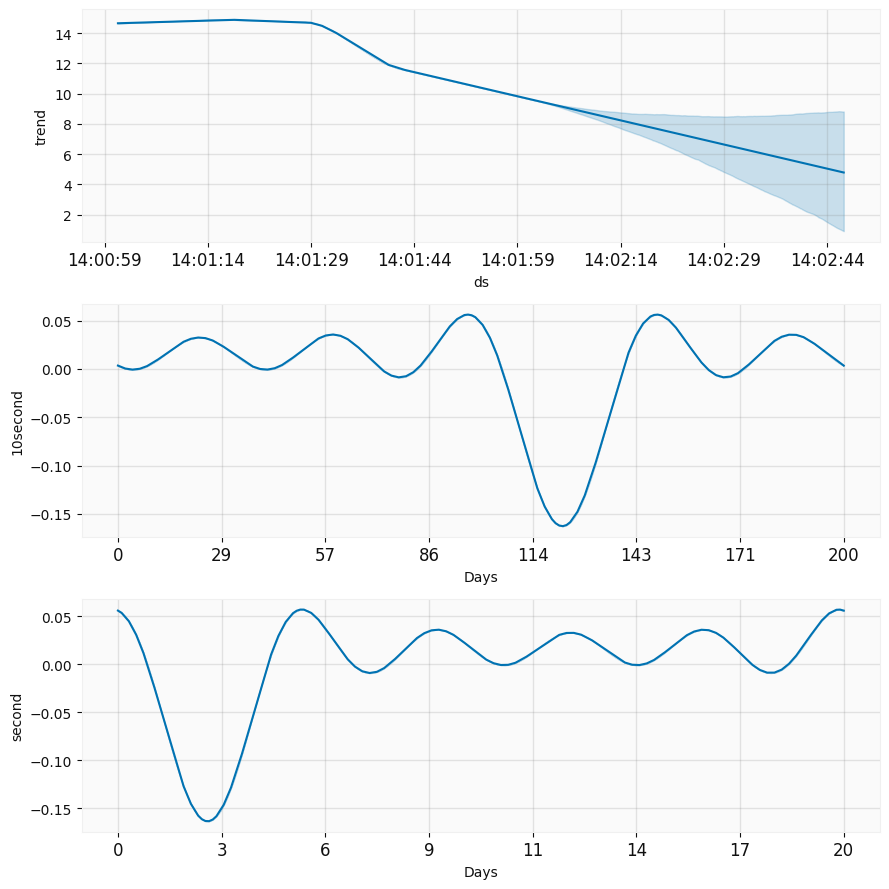

In [43]:
fig2 = m.plot_components(forecast)

18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing


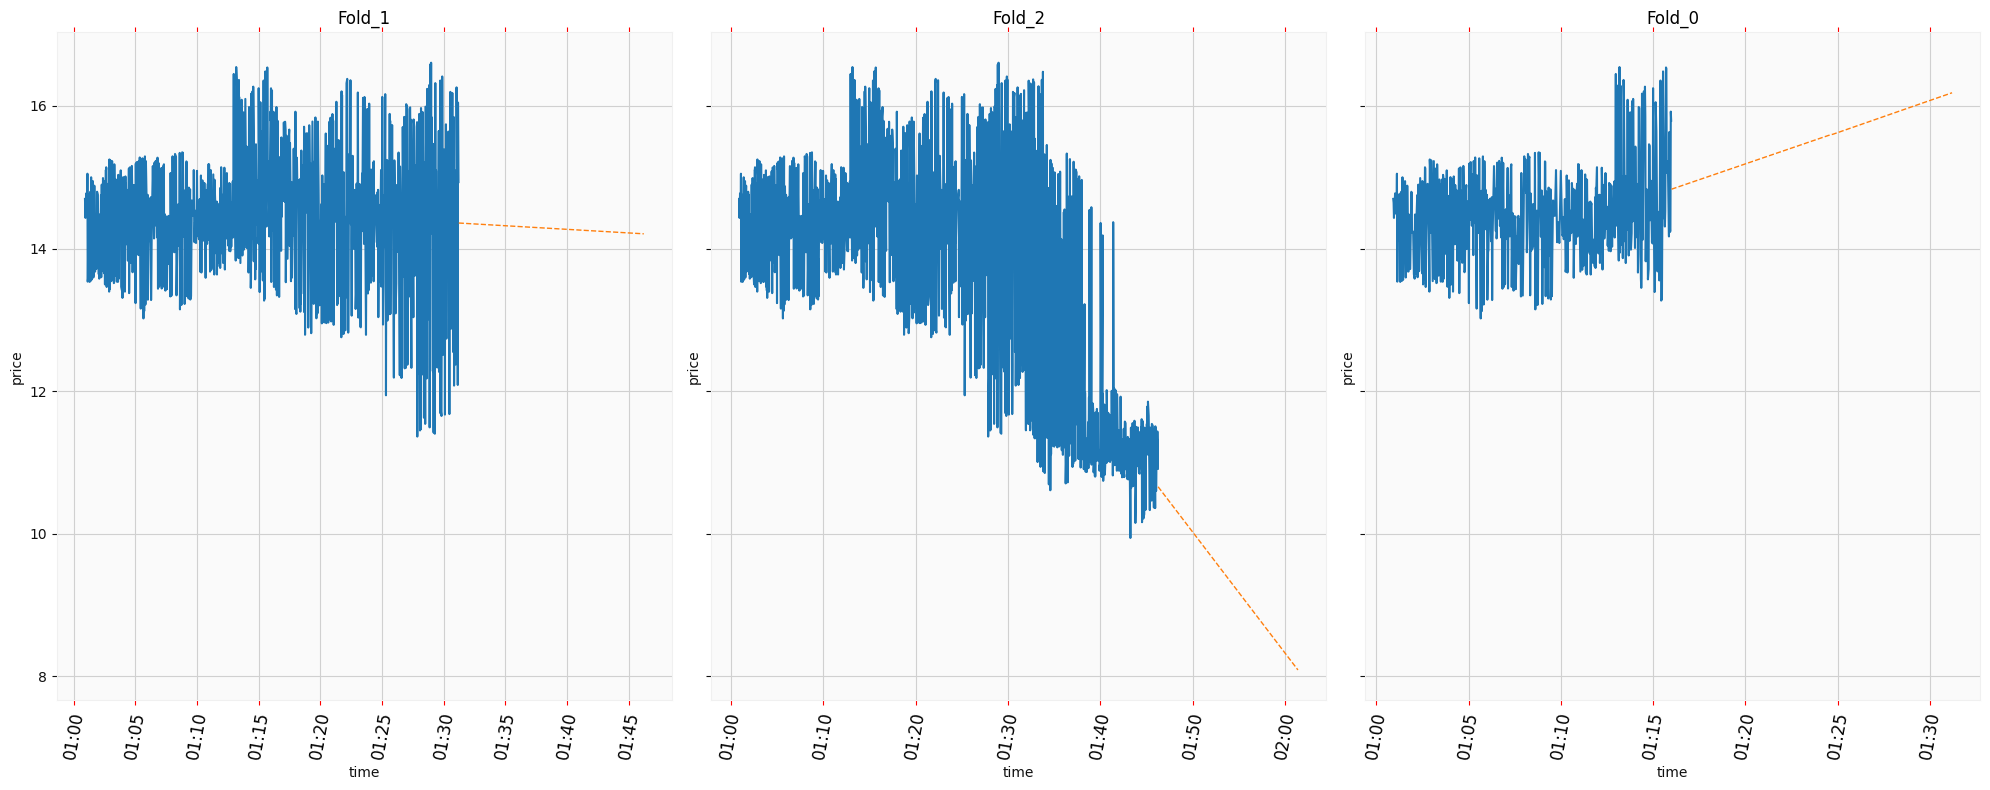

Результаты кросс-валидации Prophet  [1.5467654156832846, 2.6393563438518344, 1.4147045169124057] максимальное время обучения фолда = 1.301346


In [44]:
rmsez=[]
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))
max_time = 0
for fold, (train_index, test_index) in enumerate(tscv.split(df_pr)):
    t_start = datetime.now()
    m = Prophet(weekly_seasonality=False)
    m.add_seasonality(name='20ms', period=20, fourier_order=3)
    m.add_seasonality(name='200ms', period=200, fourier_order=3)
    m.fit(df_pr.iloc[train_index])
    future = m.make_future_dataframe(periods=len(test_index)*5,freq='20ms')
    forecast = m.predict(future)
    tt=df_pr.iloc[train_index].iloc[-1]['ds']
    real_forecast = forecast[forecast['ds']>tt]
    pred=real_forecast['yhat'].head(len(test_index))

    loss = mean_squared_error(df_pr.iloc[test_index].reset_index()['y'], pred.astype(float), squared=False)
    rmsez.append(loss)

    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()

    axs[fold-1].plot(df_pr.iloc[train_index].index, df_pr.iloc[train_index]['y'])
    axs[fold-1].set(xlabel='time', ylabel='price',title='Fold_{}'.format(fold))
    axs[fold-1].plot(df_pr.iloc[test_index].index, pred,'--',linewidth=1)
    
    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
    axs[fold-1].tick_params(top=True, labeltop=False, color='red', axis='x',
        labelcolor='black', rotation=80)
    t_end = datetime.now()
    max_time =max(max_time, (t_end-t_start).total_seconds())
plt.show()
print("Результаты кросс-валидации Prophet ",rmsez, "максимальное время обучения фолда =", max_time)

In [45]:
l=['Prophet']+rmsez+[mean(rmsez)] + [max_time]
eva.loc[len(eva)] = l
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE,time
0,STL,1.337357,3.342988,1.572778,2.084375,0.429003
1,Prophet,1.546765,2.639356,1.414705,1.866942,1.301346


# Модель на базе SARIMAX

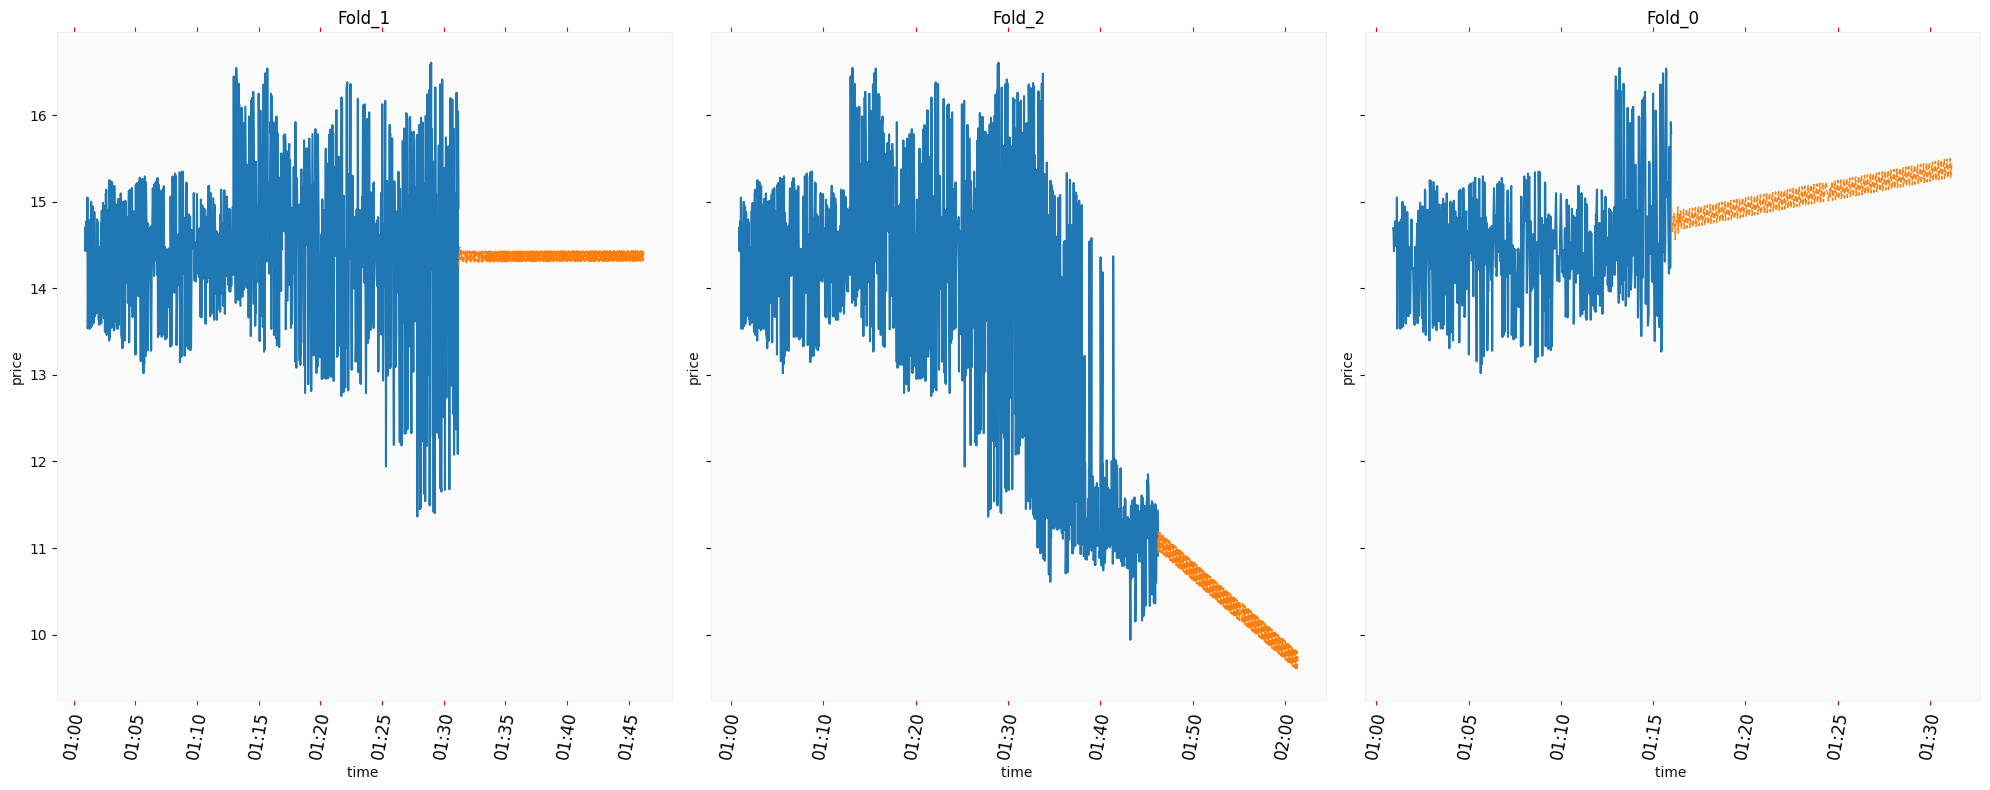

Результаты кросс-валидации SARIMAXa  [1.2484050721454678, 2.7364998371446765, 1.249852941281267] максимальное время обучения фолда = 14.602507


In [46]:
rmsez=[]
t=dft['close'][:train_size]

fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True,figsize=(20, 8))
max_time = 0
for fold, (train_index, test_index) in enumerate(tscv.split(t)):
    t_start = datetime.now()
    sarimax=sm.tsa.statespace.SARIMAX(t[train_index],order=(1, 1, 1),seasonal_order=(1,1,4,8))
    resultz=sarimax.fit()
    pred=resultz.predict(start=len(train_index),end=len(train_index)+len(test_index)-1,dynamic=True)
    loss = mean_squared_error(t[test_index], pred, squared=False)
    rmsez.append(loss)

    axs[fold-1].plot(t[train_index].index, t[train_index].values)
    axs[fold-1].set(xlabel='time ', ylabel='price',title='Fold_{}'.format(fold))
    axs[fold-1].plot(t[test_index].index, pred,'--',linewidth=1)
    axs[fold-1].xaxis.set_major_formatter(formatter)
    axs[fold-1].grid()
    axs[fold-1].tick_params(top=True, labeltop=False, color='red', axis='x',
        labelcolor='black', rotation=80)
    t_end = datetime.now()
    max_time =max(max_time, (t_end-t_start).total_seconds())
plt.show()
print("Результаты кросс-валидации SARIMAXa ",rmsez, "максимальное время обучения фолда =", max_time)

In [47]:
l=['SARIMAX']+rmsez+[mean(rmsez)] + [max_time]
eva.loc[len(eva)] = l
eva

,Model,RMSE Fold1,RMSE Fold2,RMSE Fold3,Усреднённое RMSE,time
0,STL,1.337357,3.342988,1.572778,2.084375,0.429003
1,Prophet,1.546765,2.639356,1.414705,1.866942,1.301346
2,SARIMAX,1.248405,2.736500,1.249853,1.744919,14.602507


Все наши модели дают примерно одинаковые метрики, но Prophet даёт лучшую комбинацию скорости и точности, попробуем её и исипользовать для наших дальнейших симуляций.   
Если конечно она покаже не самые плохие резульаты на тестовой выборке

# Тестирование лучшей модели

In [48]:
def get_prophet_forecast(data,horizon):
    '''
    Процедура для получения прогноза и от нашей лучшей модели и времени, которое он потребовал
    :param data: (data frame) Цены закрытия, c интексом формата datetime. это наша обучающая выборка
    :param horizon: (int) количество периодов на которое мы хотим получить прогноз
    :return: (series, float) серия прогнозных данных модели и количество секунд, потраченных на обучение
    '''
    t_start = datetime.now()
    m = Prophet(weekly_seasonality=False)
    m.add_seasonality(name='20ms', period=20, fourier_order=3)
    m.add_seasonality(name='200ms', period=200, fourier_order=3)
    m.fit(data)
    future = m.make_future_dataframe(periods=(horizon)*3,freq='20ms')
    forecast = m.predict(future)
    tt=data.iloc[-1]['ds']
    real_forecast = forecast[forecast['ds']>tt]
    pred=real_forecast.head(horizon)
    r1 = np.array(pred['yhat'])*1.05
    r2 = np.array(pred['yhat'])*0.95
    y_hat = np.random.uniform(r1, r2)
    t_end=datetime.now()
    w = t_end - t_start
    return pd.Series(y_hat, index=pred['ds']), w.total_seconds()

18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing


MRSE(test)= 1.1556209342418218
Время обучения и прогнозирования= 1.195998


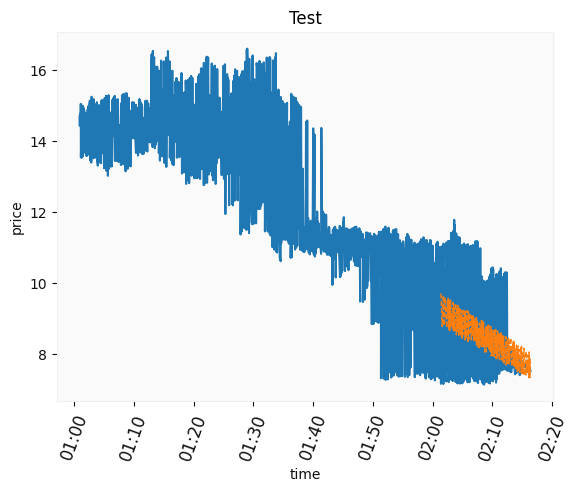

In [49]:
train_size=int(round(0.8*len(dft),0))
test_size = len(dft)-train_size
t=df_pr[:train_size]
horizon=test_size
pred, wrk_time = get_prophet_forecast(t,horizon)
print('MRSE(test)=',mean_squared_error(dft['close'].tail(test_size), pred.astype(float), squared=False))
print('Время обучения и прогнозирования=',wrk_time)
pred.index=dft['close'].tail(test_size).index
plt.plot(dft['close'])
plt.xlabel('time')
plt.xticks(rotation=70)
plt.ylabel('price')
plt.title('Test')
plt.plot(pred,'--',linewidth=1)
   
plt.gca().xaxis.set_major_formatter(formatter)
plt.grid()
plt.show()

Метрика на тестовой выборке несильно отличается от средней по кросс-валидации. Так что окончательно можно утвердиться в нашем выборе.

# Симуляция

Для начала проверим, проверим, насколько мы сможем сократить время работы нашей модели, чтобы успевать получать прогнозы внутри интересующего нас интервала.

In [50]:
stats=pd.DataFrame(columns=['train_size','horizon','RMSE','time'])
for i in trange(9):
    train_size=int(round((len(dft)*(i+1)*0.1),0))
    t=df_pr[:train_size]
    horizon=int(round(train_size/2,0))
    if train_size + horizon > len(dft):
        horizon = len(dft)-train_size-1
    pred, wrk_time = get_prophet_forecast(t,horizon)
    rmse_ = mean_squared_error(dft['close'].iloc[train_size+1:train_size+horizon+1], pred.astype(float), squared=False)
    stats.loc[len(stats)]=[train_size,horizon,rmse_,wrk_time]
stats

  0%|          | 0/9 [00:00<?, ?it/s]18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
 11%|█         | 1/9 [00:00<00:01,  4.16it/s]18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
 22%|██▏       | 2/9 [00:00<00:02,  3.02it/s]18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 3/9 [00:01<00:02,  2.14it/s]18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
 44%|████▍     | 4/9 [00:02<00:03,  1.61it/s]18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing
 56%|█████▌    | 5/9 [00:03<00:03,  1.31it/s]18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 6/9 [00:04<00:02,  1.09it/s]18:30:56 - cmds

,train_size,horizon,RMSE,time
0,376.0,188.0,0.610103,0.240391
1,751.0,376.0,1.223674,0.391962
2,1126.0,563.0,1.458998,0.627000
3,1502.0,751.0,2.667916,0.858513
4,1878.0,939.0,2.225645,1.008449
5,2253.0,1126.0,1.632127,1.223350
6,2628.0,1126.0,1.255493,1.274999
7,3004.0,750.0,1.151223,1.288225
8,3380.0,374.0,1.246326,0.979018


1126 наблюдейний выглядит как хорошая кобинация скорости вычислений и точности, но мы попробуем разные варианты.

In [51]:
def get_deprado_table(data, lookback=5, alpha=0.75, time_to_hold=1000):
    '''
    Процедура для значений трёх барьеров ДеПраодо
    :param data: (data frame) Цены закрытия, c интексом формата datetime. это наша обучающая выборка
    :param lookback: (int) длинна предшествующего периода для рассчёта волатильности
    :alpha: (float) коэффициент риск-апетита, показывающий во сколько раз наши пороги take-profit и stop-loss отлиаются от скользящей волатильности
    :time_to_hold: (int) максимальное время нахождения в позиции в милисекундах
    :return: (data frame) исходный датафрейм с добавлением всех необходимых для работы моделей колонок
    '''
    deprado = pd.DataFrame()
    deprado['close']=data
    deprado.index=data.index

    # Определяем скользящую волатильность, исходя из 5 прошлых свечей
    vol = get_daily_vol(close=data, lookback=lookback)
    deprado['vol']=vol
    #print('Строим горизонатальные барьеры')
    deprado = set_h_barriers(deprado, alpha=alpha)
    #print('Строим вертикальный барьер')
    deprado['exit_postion'] = deprado.index+timedelta(milliseconds=time_to_hold)
    #print('Готово')
    return deprado

In [75]:
train_size = 376
time_to_hold = 20
horizon=int(round(train_size/2,0)+time_to_hold)
pred, wrk_time = get_prophet_forecast(df_pr[:train_size],horizon)
print('Time taken:',wrk_time)
deprado1 = get_deprado_table(pred, lookback=int(time_to_hold*0.8), alpha=1.75, time_to_hold=time_to_hold)

18:40:07 - cmdstanpy - INFO - Chain [1] start processing
18:40:07 - cmdstanpy - INFO - Chain [1] done processing


Time taken: 0.26452


In [76]:
deprado1=deprado1.dropna()
deprado1.head()

,close,vol,stop_loss,take_profit,exit_postion
ds,,,,,
2023-11-28 14:01:08.820,14.940809,0.035811,14.878139,15.003479,2023-11-28 14:01:08.840
2023-11-28 14:01:08.840,13.924002,0.039673,13.854573,13.993430,2023-11-28 14:01:08.860
2023-11-28 14:01:08.860,14.375171,0.039816,14.305493,14.444850,2023-11-28 14:01:08.880
2023-11-28 14:01:08.880,14.344249,0.038587,14.276722,14.411777,2023-11-28 14:01:08.900
2023-11-28 14:01:08.900,14.807392,0.039243,14.738718,14.876066,2023-11-28 14:01:08.920


In [77]:
def get_signal_now333(df,time_to_hold=20):
    """
    Эта процедура генерирует сигналы на осовен трёхбарьерного алгоритма ДеПрадо, основываясь на прогнозе цен.

    Args:
        df (dataframe): набор данных, содержащих прогнозную цену (close), и рассчитанные на прошлых этапах параметры stop_loss и take_profit
        time_to_hold (int): максимальное время нахождения в позиции в количестве свечей
    Return:
        list(final_tp), list(final_sl): два листа с сигналами для take_profit и stop_loss, соответственно
    """
    submission = df.copy()
    #Чтобы всё считалось быстрее используем вектора numpy и обойдёмся без циклов
    close_arr=np.array(submission['close'])
    sl_arr=np.array(submission['stop_loss'])
    tp_arr=np.array(submission['take_profit'])
    #Найдём скользящий максимум и его номер в окне равном time_to_hold
    running_max = np.max(sliding_window_view(close_arr, window_shape = time_to_hold), axis = 1)
    running_max_idx = np.argmax(sliding_window_view(close_arr, window_shape = time_to_hold), axis = 1)
    #Найдём скользящий минимум и его номер в окне равном time_to_hold
    running_min = np.min(sliding_window_view(close_arr, window_shape = time_to_hold), axis = 1)
    running_min_idx = np.argmin(sliding_window_view(close_arr, window_shape = time_to_hold), axis = 1)
    #Добавим нулей в конец, так как к концу вектора наше окно будет заглядывать в пустоту, где ещё нет прогнозных данных
    running_max=np.pad(running_max, (0, time_to_hold-1), mode='constant')
    running_min=np.pad(running_min, (0, time_to_hold-1), mode='constant')
    #Проверим какой барьер был пробит первым, сравним между собой номера скользящего минимума и максимума
    max_first = (running_max_idx < running_min_idx).astype(int)
    min_first = (running_min_idx < running_max_idx).astype(int)
    hit_tp = running_max > tp_arr
    hit_tp = hit_tp.astype(int)
    max_first = np.pad(max_first, (0, time_to_hold-1), mode='constant')
    min_first = np.pad(min_first, (0, time_to_hold-1), mode='constant')
    #Получим сигналы
    final_tp = max_first * hit_tp
    hit_sl = running_min < sl_arr
    hit_sl = hit_tp.astype(int)*(-1)
    final_sl = min_first * hit_sl
    return list(final_tp), list(final_sl)

In [78]:
deprado1['tp_signal'],deprado1['sl_signal'],  = get_signal_now333(deprado1,time_to_hold)
deprado1.tail(100)


,close,vol,stop_loss,take_profit,exit_postion,tp_signal,sl_signal
ds,,,,,,,
2023-11-28 14:01:10.660,14.533369,0.048025,14.449326,14.617413,2023-11-28 14:01:10.680,1,0
2023-11-28 14:01:10.680,14.796745,0.047914,14.712895,14.880595,2023-11-28 14:01:10.700,1,0
2023-11-28 14:01:10.700,15.111665,0.048159,15.027387,15.195944,2023-11-28 14:01:10.720,0,0
2023-11-28 14:01:10.720,14.299433,0.045357,14.220057,14.378808,2023-11-28 14:01:10.740,0,-1
2023-11-28 14:01:10.740,14.500263,0.045434,14.420753,14.579772,2023-11-28 14:01:10.760,1,0
...,...,...,...,...,...,...,...
2023-11-28 14:01:12.560,14.182399,0.035205,14.120791,14.244007,2023-11-28 14:01:12.580,0,0
2023-11-28 14:01:12.580,14.516083,0.035608,14.453769,14.578398,2023-11-28 14:01:12.600,0,0
2023-11-28 14:01:12.600,14.745274,0.035207,14.683662,14.806886,2023-11-28 14:01:12.620,0,0


In [83]:
deprado1.index[:5]

DatetimeIndex(['2023-11-28 14:01:08.820000', '2023-11-28 14:01:08.840000',
               '2023-11-28 14:01:08.860000', '2023-11-28 14:01:08.880000',
               '2023-11-28 14:01:08.900000'],
              dtype='datetime64[ns]', name='ds', freq=None)

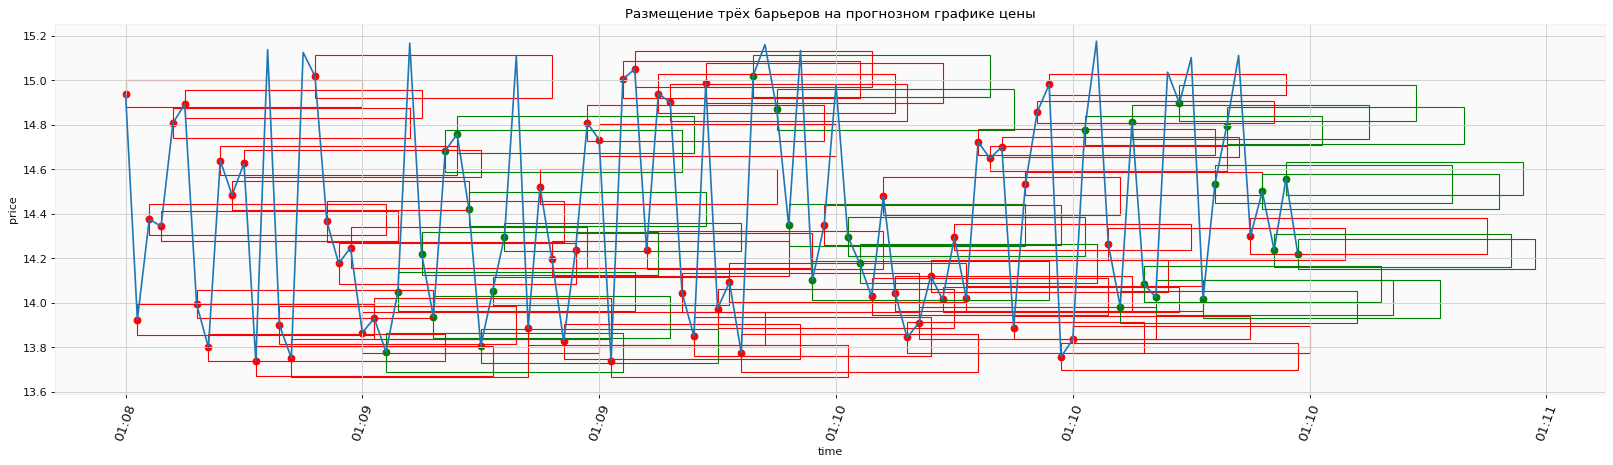

In [95]:
def format_fn(tick_val, tick_pos):
    if int(tick_val) in range(len(d1)+40):
        sss = deprado1.index[int(tick_val)]
        return datetime.strftime(sss, '%M:%S')
    else:
        return ''

figure(figsize=(25, 6), dpi=80)
d1=deprado1[:100].copy()
d1.index=range(len(d1))
plt.plot(d1['close'])
plt.scatter(x=d1[d1['tp_signal']==1].index, y=d1[d1['tp_signal']==1]['close'], c='green')
plt.scatter(x=d1[d1['sl_signal']==-1].index, y=d1[d1['sl_signal']==-1]['close'], c='red')
plt.plot()
# Add a rectangle using Matplotlib
for index, row in d1.iterrows():
    if row['tp_signal'] == 1:
        side = row['take_profit']-row['stop_loss']
        rect = plt.Rectangle((index, row['close']-side/2), time_to_hold, side, linewidth=1, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)
    if row['sl_signal'] == -1:
        side = row['take_profit']-row['stop_loss']
        rect = plt.Rectangle((index, row['close']-side/2), time_to_hold, side, linewidth=1, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
plt.gca().xaxis.set_major_formatter(format_fn)
plt.xlabel('time')
plt.xticks(rotation=70)
plt.ylabel('price')
plt.title('Размещение трёх барьеров на прогнозном графике цены')
plt.show()

In [57]:
#Начинаем подавать реальные данные и получать сигналы от модели
deprado1['real_price']=dft['close'].loc[deprado1.index]
deprado1.head(5)

,close,vol,stop_loss,take_profit,exit_postion,tp_signal,sl_signal,real_price
ds,,,,,,,,
2023-11-28 14:01:08.820,14.050773,0.034198,13.990927,14.110619,2023-11-28 14:01:08.840,1,0,14.808
2023-11-28 14:01:08.840,14.982696,0.038181,14.915880,15.049513,2023-11-28 14:01:08.860,1,0,14.715
2023-11-28 14:01:08.860,13.964343,0.038336,13.897256,14.031430,2023-11-28 14:01:08.880,1,0,15.344
2023-11-28 14:01:08.880,14.097280,0.037665,14.031366,14.163193,2023-11-28 14:01:08.900,1,0,14.645
2023-11-28 14:01:08.900,14.051379,0.036988,13.986650,14.116108,2023-11-28 14:01:08.920,1,0,14.286


In [58]:
def buy_stocks(row, cash_amount, book, fee_size,index):
    """
    Эта процедура симулирует покупку акций.

    Args:
        row (series): строка из нашего набора данных ДеПрадо, где есть реальная цена, уровне барьеров
        cash_amount (float): размер свободных денежных средств для покупки
        book (dataframe): набор данных где хранятся данные о совершённых сделках
        fee_size (float): размер комиссии за покупку
        index (datetime): время на которое приведена котировка
    Return:
        cash_amount(float), book(dataframe): остаток денег после заключения/незаключения сделки и набор данных о совершённых операциях
    """
    if cash_amount > 0 and row['real_price'] < row['take_profit']:
        enter = index
        amount = round(cash_amount/row['real_price'],0)-1
        balance_price = row['real_price']
        fee = amount * balance_price * fee_size
        take_profit_ =  row['take_profit']
        stop_loss_ =  row['stop_loss']
        total_value = amount * balance_price
        result = -1*fee
        cash_amount = round(cash_amount - total_value - fee,2)
        if amount > 0:
            book.loc[len(book)] = [
                                    enter,
                                    amount,
                                    balance_price,
                                    stop_loss_,
                                    take_profit_,
                                    total_value,
                                    fee,
                                    result,
                                    '-',
                                    '-'
                                ]
    return cash_amount, book


In [59]:
def sell_stocks(row, cash_amount, book, fee_size, time_of_sell):
        """
    Эта процедура продажу акций.

    Args:
        row (series): строка из нашего набора данных ДеПрадо, где есть реальная цена, уровне барьеров
        cash_amount (float): размер свободных денежных средств для покупки
        book (dataframe): набор данных где хранятся данные о совершённых сделках
        fee_size (float): размер комиссии за покупку
        time_of_sell (datetime): время на которое приведена котировка
    Return:
        cash_amount(float), book(dataframe): остаток денег после заключения/незаключения сделки и набор данных о совершённых операциях
    """
    if book['amount'].sum() > 0:
        for index, stock in book.iterrows():
            if (row['real_price'] >= stock['take_profit'] or row['real_price'] <= stock['stop_loss']) and (stock['amount'] > 0):
                fee = stock['amount'] * row['real_price'] * fee_size
                result = round(((row['real_price'] * stock['amount'] - stock['total_value']) - fee),2)
                cash_amount = round(cash_amount + row['real_price'] * stock['amount'] - fee)
                stock['fee'] = stock['fee'] + fee
                stock['result'] = stock['result'] + result
                stock['amount'] = 0
                stock['total_value'] = 0
                stock['price_sold'] = row['real_price']
                stock['exit'] = time_of_sell
                enter = stock['enter']
                try:
                    book[book['enter'] == enter] = stock
                except:
                    pass  
    return cash_amount, book

In [60]:
CASH = 100
FEE = 0.001
STOCKS = 0
LIMIT = 4
actvie_positions = pd.DataFrame(columns = ['enter', 'amount', 'balance_price', 'stop_loss', 'take_profit','total_value','fee','result','price_sold', 'exit'])
for index, row in tqdm(deprado1.iterrows()):
    if actvie_positions['amount'].sum() > 0:
        CASH, actvie_positions = sell_stocks(row, CASH, actvie_positions, FEE, index)
    if row['tp_signal'] == 1:
        CASH, actvie_positions = buy_stocks(row, CASH, actvie_positions, FEE, index)

192it [00:00, 1958.46it/s]


In [61]:
def highlight_row(row):
    "Простая процедура для форматирования выводимого набора данных"
    if 'profit' in row.index:
        c = 'profit'
    if 'result' in row.index:
        c = 'result'
    color = 'green' if float(row[c]) > 0 else 'red'
    return [f'background-color: {color}' for _ in range(len(row))]


In [62]:
l = ['amount','fee','total_value','result']
for i in l:
    actvie_positions[i] = actvie_positions[i].map(lambda x: f"{x:.1f}")


In [63]:
styled_df = actvie_positions.style.apply(highlight_row, axis=1)
# Display the styled DataFrame
styled_df

,enter,amount,balance_price,stop_loss,take_profit,total_value,fee,result,price_sold,exit
0,2023-11-28 14:01:08.840000,0.0,14.715000,14.915880,15.049513,0.0,0.2,3.6,15.344000,2023-11-28 14:01:08.860000
1,2023-11-28 14:01:08.920000,0.0,14.166000,14.495573,14.626778,0.0,0.2,3.3,14.749000,2023-11-28 14:01:08.940000
2,2023-11-28 14:01:08.980000,0.0,14.330000,14.259933,14.392566,0.0,0.2,-6.8,13.223000,2023-11-28 14:01:09
3,2023-11-28 14:01:09,0.0,13.223000,14.146514,14.279450,0.0,0.2,3.6,13.759000,2023-11-28 14:01:09.020000
4,2023-11-28 14:01:09.020000,0.0,13.759000,13.790785,13.925135,0.0,0.2,3.0,14.214000,2023-11-28 14:01:09.040000
5,2023-11-28 14:01:09.040000,0.0,14.214000,14.479403,14.608108,0.0,0.2,3.4,14.730000,2023-11-28 14:01:09.060000
6,2023-11-28 14:01:09.080000,0.0,14.177000,14.732434,14.866254,0.0,0.2,0.7,14.310000,2023-11-28 14:01:09.100000
7,2023-11-28 14:01:09.120000,0.0,13.739000,13.727563,13.873190,0.0,0.2,10.2,15.223000,2023-11-28 14:01:09.140000
8,2023-11-28 14:01:09.180000,0.0,13.332000,14.875205,14.999783,0.0,0.2,6.9,14.221000,2023-11-28 14:01:09.200000
9,2023-11-28 14:01:09.200000,0.0,14.221000,14.115771,14.249267,0.0,0.2,4.4,14.801000,2023-11-28 14:01:09.220000


In [64]:
def sharpe_ratio(return_series, N, rf):
        """
    Вычисляет коэффициент Шарпа

    Args:
        return_series (series): набор данных, где индекс это время, есть колонки 'price' - цена и 'volume' - объём.
        N (int): количество дней в периоде
        rf (float): ставка безрисковой доходности

    Return:
        (float): коэффициент Шарпа
    """
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

N = 255 #255 trading days in a year
rf =0.01 #1% risk free rate
sharpes = sharpe_ratio(actvie_positions['result'].astype('float'), N, rf)

In [65]:
print("Коэффициент Шарпа для нашей статегии составил", sharpes)
time = actvie_positions['exit'].max() - actvie_positions['enter'].min()
print("За ", time.total_seconds(), "cекунды мы бы заработали ", CASH-100)

Коэффициент Шарпа для нашей статегии составил 6.085763258877233
За  3.44 cекунды мы бы заработали  70


# Полная симуляция
Теперь мы усовершенствуем нашу симуляцию, добавив ряд полезных элементов.  
1) По мере того как проходит время, модель будет обновлять прогноз и отрпавлять его алгоритму для дальнешей работы.
2) Мы огничим количество сделок, которые алгоритм может реализовать за 1 минуту.
3) Мы посмотрим как отрабатывает алгоритм при разных гипер-параметрах.

In [66]:
stats

,train_size,horizon,RMSE,time
0,376.0,188.0,0.610103,0.240391
1,751.0,376.0,1.223674,0.391962
2,1126.0,563.0,1.458998,0.627000
3,1502.0,751.0,2.667916,0.858513
4,1878.0,939.0,2.225645,1.008449
5,2253.0,1126.0,1.632127,1.223350
6,2628.0,1126.0,1.255493,1.274999
7,3004.0,750.0,1.151223,1.288225
8,3380.0,374.0,1.246326,0.979018


In [104]:
def fill_real_price(dft, deprado):
    """
    Во время симуляции обнаружилось, что в нашем исходном временном ряду есть пропуски, а прогноз на это плохо реагирует.
    Эта процедура заполняет пропуски значениями предыдущего ряда, если находит

    Args:
        dft (series): набор данных, где индекс это время, есть колонки 'close' - цена
        deprado (series): набор данных, в котором есть прогноз цен на этот же период, но без пропусков

    Return:
        (series): преобразованных ряд, в котором пропуски заполнены предыдущими рядами
    """
    dftc = dft.copy()
    dftc = dftc[deprado.index[0]:]
    for i in range(len(deprado.index)):
        if deprado.index[i] != dftc.index[i]:
            dftc.loc[deprado.index[i]] = dftc.iloc[i-1]
    return dftc


In [100]:
def test_triple_barrier_model(dft_, train_size_=376,time_to_hold_=50, alpha = 1.75, deals_per_minute=60):
    """
    Это ядро нашей симуляции. Она берёт набор данных с реальными ценами, строит прогноз, для прогноза получает сигналы на основе трёхбарьерного алгоритма,
    а потом уже подаёт алгоритму данные о реальных ценах, и на основании них исполняет сделки и считает результат от торговли.
    Args:
        dft (dataframe): набор данных, где индекс это время, есть колонка 'close' - цена
        train_size_ (int): размер части данных, используемой для обучения модели
        time_to_hold_(int): максимальное время нахождения в позиции, выраженное в количестве свечей
        alpha (float): коэффициент риск-апетита, показывающий во сколько раз наши пороги take-profit и stop-loss отлиаются от скользящей волатильности 
        deals_per_minute (int): количество сделок, которые алгоритм успевает провести за одну минуту
    Return:
        (dataframe): набор данных с результатами торговли
    """       
    str_results = pd.DataFrame(columns = ['train_size','sharpe','time','profit'])
    actvie_positions = pd.DataFrame(columns = ['enter', 'amount', 'balance_price', 'stop_loss', 'take_profit','total_value','fee','result','price_sold', 'exit'])
    dft = dft_.copy()
    df_pr = pd.DataFrame()
    df_pr['close'] = dft['close']
    df_pr['date'] = df_pr.index
    time_to_hold = time_to_hold_
    df_pr = df_pr.rename(columns={'date': 'ds', 'close': 'y'})
    horizon=int(round(train_size_/2,0)+time_to_hold)
    was_deal = False
    for i in range(int(np.floor((len(dft)-train_size)/horizon))):
        extended_train_size = train_size+horizon*(i)
        if extended_train_size > len(dft)-horizon:
            extended_train_size = len(dft)-horizon
        pred, wrk_time = get_prophet_forecast(df_pr[:extended_train_size],horizon)
        deprado2 = get_deprado_table(pred, lookback=int(time_to_hold*0.8), alpha=alpha, time_to_hold=time_to_hold)
        deprado2=deprado2.dropna()
        deprado2['tp_signal'],deprado2['sl_signal'],  = get_signal_now333(deprado2,time_to_hold)
        #Начинаем подавать реальные данные и получать сигналы от модели
        try:
            deprado2['real_price']=dft['close'].loc[deprado2.index]
        except:
            dft_filtered = fill_real_price(dft, deprado2)
            deprado2['real_price']=dft_filtered['close'].loc[deprado2.index]
        CASH = 100
        FEE = 0.001
        last_deal = deprado2.index[0]
        #Начинаем торговать
        for index, row in deprado2.iterrows():

            if index >=last_deal + timedelta(seconds=(60/deals_per_minute)):
                last_deal = index
                was_deal = False
            if actvie_positions['amount'].sum() > 0 and not was_deal:
                c1 = CASH
                CASH, actvie_positions = sell_stocks(row, CASH, actvie_positions, FEE, index)
                if CASH != c1:
                    was_deal = True
            if row['tp_signal'] == 1 and not was_deal:
                c1 = CASH
                CASH, actvie_positions = buy_stocks(row, CASH, actvie_positions, FEE, index)
                if CASH != c1:
                    was_deal = True
    time_in = actvie_positions['exit'].max() - actvie_positions['enter'].min()        
    str_results.loc[len(str_results)] = [
                                            train_size,
                                            sharpe_ratio(actvie_positions['result'].astype('float'), N, rf),
                                            time_in.total_seconds(),
                                            CASH-100]

    return str_results



In [101]:
full_results = pd.DataFrame(columns=['train_size','time_to_hold','alpha','sharpe','time','profit'])
for ts in tqdm(stats['train_size'][2:5]):
    for hold in range(100,200,25):
        for alpha in [0.75,1,1.5,2]:
            str_results1 = test_triple_barrier_model(dft, train_size_=ts,time_to_hold_=hold,alpha=alpha,deals_per_minute=60)
            str_results1['time_to_hold']=hold
            str_results1['alpha']=alpha
            full_results = pd.concat([full_results, str_results1], axis=0)

  0%|          | 0/3 [00:00<?, ?it/s]19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] start processing
19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:37 - cmdstanpy - INFO - Chain [1] start processing
19:43:37 - cmdstanpy - INFO - Chain [1] done processing
19:43:38 - cmdstanpy - INFO - Chain [1] start processing
19:43:38 - cmdstanpy - INFO - Chain [1] done processing
19:43:39 - cmdstanpy - INFO - Chain [1] start processing
19:43:40 - cmdstanpy - INFO - Chain [1] done processing
19:43:40 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing
19:43:41 - cmdstanpy - INFO - Chain [1] start processing
19:43:41 - cmdstanpy - INFO - Chain [1] done processing
19:43:42 - cmdstanpy - INFO - Chain [1] start processing
19:43:42 - cmdstanpy - INFO - Chain [1] done processing
19:43:43 - cmdstanpy - INFO - Chain [1] start processing
19

Вероятность получения убытка от работы алгоритмма:0.15%
Максимальная лубина просадки:-29.00%


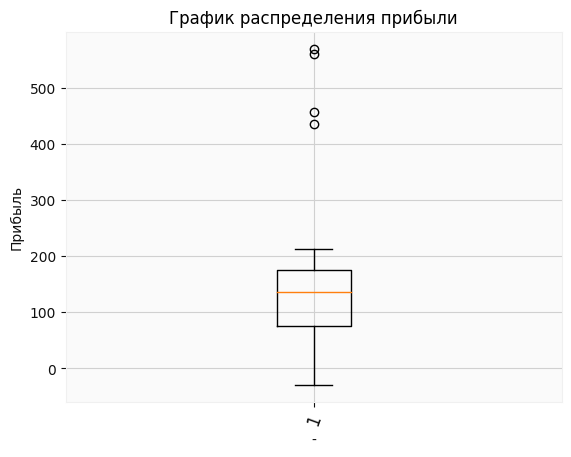

In [105]:
print('Вероятность получения убытка от работы алгоритмма:{:.2f}%'.format(len(full_results[full_results['profit']<0])/len(full_results)))
print('Максимальная лубина просадки:{:.2f}%'.format(full_results['profit'].min()))
plt.boxplot(full_results['profit'])
plt.xlabel('-')
plt.xticks(rotation=70)
plt.ylabel('Прибыль')
plt.title('График распределения прибыли')
plt.show()

**Выводы**:  
Практически при любой комбинации входных параметров наша стретгия получается прибыльной, а вероятность потерять до -29% депозита всего 0,15% что немного.

In [106]:
full_results.index = range(len(full_results))

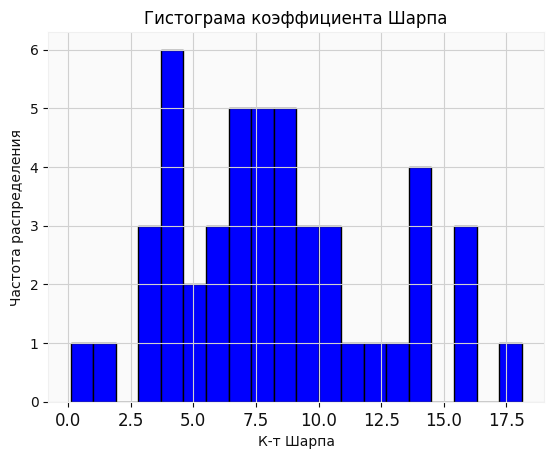

In [107]:
plt.hist(full_results['sharpe'], color = 'blue', edgecolor = 'black',
         bins = int(20))

plt.title('Гистограма коэффициента Шарпа')
plt.xlabel('К-т Шарпа')
plt.ylabel('Частота распределения')
plt.show()

Всё-таки наша модель не модет похватстаться стабильными результатами. Когда-то отрабатывает очень хорошо, кого-то средне. Но позитивным моментом явялется явный минимум около нуля.

# Итоги работы:  


1. Исходный набор данных был переведён в формат "свечей" с длительностью по 20 мс. Это позволило сохранить достаточно данных для приемлемой точности прогноза и обеспечить достойную скорость вычислений.
2. Были опробованы три модели, из которых была выбрана модель на базе Prophet, показавшея следующие основные метрики среднее MRSE на кросс-валидации 1.86 и 1.19 на тестовой выборке, при скорости обучения 1.3 секунда на 3 фолда.
3. На основе прогноза, полученного данной моделью, были получены сигналы, оперделённый на базе трёхбарьерной методики Лопеса Де Прадо.
4. Реальные данные о ценах, и полученные сигналы были добавлены в симуляци, которая имитировал процесс реальной биржевой торговли.
5. В работу алгоритма были добавлены ограничения: невозможность открытия коротких позиций, ограничение на количество сделок в минуту.
6. Симуляция была проведена для разного количества данных, разного риск-аппетита, и разного времени пребывания в позиции. В итоге алгоритм оказался достаточно консервативным, так как шанс "уйти в минус" у него менее 2%. При этом доходность оказалась нестабильной в отдельных случаях уходила за 400%, но медиана была на уровне 150%, что подозрительно хорошо, учитывая что всё это происходилао за пару минут. И это уже с учётом комиссий, но без учёта налогов.


